# Проект по А/B-тестированию

## Описание данных

***ab_project_marketing_events.csv*** — календарь маркетинговых событий на 2020 год.

Структура файла:

- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

***final_ab_new_users.csv*** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

***final_ab_events.csv*** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- user_id — идентификатор пользователя;
- event_dt — дата и время покупки;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

***final_ab_participants.csv*** — таблица участников тестов.

Структура файла:

- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

## Постановка задачи

***Задача — провести оценку результатов A/B-теста.*** В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- ***Оценить корректность проведения теста***
    - пересечение тестовой аудитории с конкурирующим тестом,
    - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
    
- ***Проанализировать результаты теста***

## Техническое задание

- Название теста: ***recommender_system_test***;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: ***тестирование изменений, связанных с внедрением улучшенной рекомендательной системы***;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page,
    - просмотры корзины — product_cart,
    - покупки — purchase.

## План работы

1. ***Загрузка данных и подготовка их к анализу***


2. ***Предобработка данных***
 - Преобразование данных к нужным типам


3. ***Оценка корректности проведения теста***
 - Соответствие данных требованиям технического задания
 - Время проведения теста
 - Аудитория теста


4. ***Исследовательский анализ данных***
 - Распределение событий на одного пользователя в выборках
 - Распределение событий и пользователей по дням
 - Изменение конверсии в воронке на разных этапах


5. ***A/B - тестирование***
 - Изменение метрик за 14 дней с момента регистрации пользователя
 - Проверка статистической разницы долей z-критерием
 

6. ***Вывод***

## Загрузка данных и подготовка их к анализу

In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Импорт библиотек
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
import scipy.stats as stats
from datetime import datetime, timedelta
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.weightstats import ztest as ztest
pd.options.mode.chained_assignment = None  # default='warn'

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [3]:
# загружаем файлы в переменные
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
try:
    events = pd.read_csv('final_ab_events.csv')
except:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
try:
    new_users = pd.read_csv('final_ab_new_users.csv')
except:
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
try:
    participants = pd.read_csv('final_ab_participants.csv')
except:
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

all_tables = [marketing_events, events, new_users, participants]

In [4]:
# выведем все таблицы вместе, чтобы разобраться в данных
for table in all_tables:
    display(table.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [5]:
# функция, выводит информацию по столбцам
def df_review(df):
    start = "\033[1m"
    end2 = "\033[0;0m"
    print(start + f'Вывод инфо' + end2, end='\n\n')
    print(df.info())
    print('---------------------------------------------------------------------------------------------------------')
    print(start + f'Вывод описания' + end2, end='\n\n')
    print(df.describe().T)
    print('---------------------------------------------------------------------------------------------------------')
    print(start + f'Количество пропусков' + end2, end='\n\n')
    print(df.isna().sum())
    print('---------------------------------------------------------------------------------------------------------')
    print(start + f'Количество пропусков в процентах' + end2, end='\n\n')
    display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))
    print('---------------------------------------------------------------------------------------------------------')
    print(start + f'Количество дублей' + end2, end='\n\n')
    print(df.duplicated().sum())

In [6]:
df_review(marketing_events)

Вывод инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
---------------------------------------------------------------------------------------------------------
Вывод описания

          count unique                       top freq
name         14     14  Christmas&New Year Promo    1
regions      14      6                      APAC    4
start_dt     14     14                2020-12-25    1
finish_dt    14     14                2021-01-03    1
---------------------------------------------------------------------------------------------------------
Количество пропусков

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
---------

,0
name,0.000000
regions,0.000000
start_dt,0.000000
finish_dt,0.000000


---------------------------------------------------------------------------------------------------------
Количество дублей

0


In [7]:
df_review(events)

Вывод инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
---------------------------------------------------------------------------------------------------------
Вывод описания

           count       mean        std   min   25%   50%   75%     max
details  62740.0  23.877631  72.180465  4.99  4.99  4.99  9.99  499.99
---------------------------------------------------------------------------------------------------------
Количество пропусков

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
-------------------------------------------------------------------------------

,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


---------------------------------------------------------------------------------------------------------
Количество дублей

0


In [8]:
df_review(new_users)

Вывод инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
---------------------------------------------------------------------------------------------------------
Вывод описания

            count unique               top   freq
user_id     61733  61733  D72A72121175D8BE      1
first_date  61733     17        2020-12-21   6290
region      61733      4                EU  46270
device      61733      4           Android  27520
---------------------------------------------------------------------------------------------------------
Количество пропусков

user_id       0
first_date    0
region        0
device        0
dtype: int64
------------------

,0
user_id,0.000000
first_date,0.000000
region,0.000000
device,0.000000


---------------------------------------------------------------------------------------------------------
Количество дублей

0


In [9]:
df_review(participants)

Вывод инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
---------------------------------------------------------------------------------------------------------
Вывод описания

         count unique                top   freq
user_id  18268  16666   0FDFDA0B2DEC2D91      2
group    18268      2                  A   9655
ab_test  18268      2  interface_eu_test  11567
---------------------------------------------------------------------------------------------------------
Количество пропусков

user_id    0
group      0
ab_test    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Количество пропусков в процентах



,0
user_id,0.000000
group,0.000000
ab_test,0.000000


---------------------------------------------------------------------------------------------------------
Количество дублей

0


<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
    
- Cтолбцы, содержащие дату, необходимо привести к нужному типу datetime
- Cтолбец details датасета events содержит в себе пропуски
- Дубликаты в данных не обнаружены   
</div>

## Предобработка данных

***Преобразование данных к нужным типам***

In [10]:
# преобразуем дату к типу datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [11]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [12]:
# смотрим, присутствуют ли пользователи, входящие в оба теста сразу
participants['user_id'].duplicated().sum()

1602

***1602 пользователя участвуют в обоих тестах сразу. Зафиксируем это.***

In [13]:
# посмотрим на пропуски
events.groupby('event_name').count().reset_index()

,event_name,user_id,event_dt,details
0,login,189552,189552,0
1,product_cart,62462,62462,0
2,product_page,125563,125563,0
3,purchase,62740,62740,62740


<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
    
- 1602 пользователя входят в обе группы.
- Дату привели к типу datetime.
- В поле details для purchase - хранится стоимость покупки в долларах. Для event_name со значением purchase пропуски отсутствуют, поэтому пропуски обрабатывать не будем. В данном случае это не ошибка.
- Количество тестов - 2 - это interface_eu_test и recommender_system_test. Преобладает interface_eu_test - кол-во пользователей 11567.
- Количество регионов - 4 - это ('EU', 'N.America', 'APAC', 'CIS'). Преобладает EU, кол-во пользователей - 46270.
- Количество устройств - 4 - это ('PC', 'Android', 'iPhone', 'Mac'). Чаще используют Android гаджеты - 27520.

</div>


## Оценка корректности проведения теста

### 1. Соответствие данных требованиям технического задания

In [14]:
# смотрим на таблицу с данными
participants.sample(10)

,user_id,group,ab_test
3469,6DF6E1615D629BA8,A,recommender_system_test
17055,CDE246B64C8F2175,A,interface_eu_test
3260,10C5F5234095555F,A,recommender_system_test
11927,B1425202D2711F90,B,interface_eu_test
11141,46DDE3779D56852E,A,interface_eu_test
12834,F1FA8F9BC8F9E45E,B,interface_eu_test
1841,8F4D2FF4619E575F,A,recommender_system_test
12313,62414CCAE9E992B3,A,interface_eu_test
6048,9073CEFFB95784BA,A,recommender_system_test
10456,10C9D10027ABBD7D,A,interface_eu_test


In [15]:
# смотрим распределение тестов в столбце ab_test
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64


- ***Название теста верное - recommender_system_test, в таблице есть данные по конкурирующему тесту interface_eu_test***
- ***Группа А — контрольная, B — новая платёжная воронка.***  


In [16]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [17]:
# делаем фильтр до 21 декабря
new_new_users = new_users[new_users['first_date'] <= "2020-12-21 00:00:00"]

In [18]:
new_new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [19]:
# фильтр по нужному нам тесту
recom_users = new_new_users[new_new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]

In [20]:
# проверяем даты запуска теста и дата окончания набора новых пользователей
display(recom_users['first_date'].min())
recom_users['first_date'].max()

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-21 00:00:00')

***Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020***

In [21]:
#смотрим дату последнего события
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

***Дата последнего события - 30 декабря 2020, по ТЗ тест должен длится до 4 января 2021.***

In [22]:
display(recom_users['region'].value_counts())
display(new_new_users['region'].value_counts())

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

In [23]:
# Считаем процент пользователей из EU
round((recom_users.query('region == "EU"')['region'].count()/new_new_users.query('region == "EU"')['region'].count())*100,2)

15.0

***Аудитория теста - это в основном пользователи из Европы, также присутствуют пользователи из других стран. По ТЗ сказано, что аудиторией теста должны быть 15% новых пользователей из региона EU, по данным видно, что аудитория из Европы составляет 6351 из всех 43340 новых клиентов с этого региона, что соответствует ТЗ в 15%.***

### <p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
- Название теста верное - recommender_system_test, в таблице есть данные по конкурирующему тесту interface_eu_test
- Группа А — контрольная, B — новая платёжная воронка.
- Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020
- Дата последнего события - 30 декабря 2020, по ТЗ тест должен длится до 4 января 2021
- Аудитория теста - это в основном пользователи из Европы, также присутствуют пользователи из других стран. По ТЗ сказано, что аудиторией теста должны быть 15% новых пользователей из региона EU, по данным видно, что аудитория из Европы составляет 6351 из всех 43340 новых клиентов с этого региона, что соответствует ТЗ в 15%.
</div>

### 2. Время проведения теста

***Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями.***

In [24]:
marketing_events.query('"2020-12-07" < start_dt < "2021-01-03"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
    
В наш временной период попадают 2 акции. Акция Christmas&New Year Promo может оказать большее влияние, т.к. даты её проведения попадают в исследуемый период с 12 декабря - по 4 января, плюс эта акция проводится в регионе EU, именно этот регион преобладает в тесте.
    
</div>

### 3. Аудитория теста

Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно

***Ранее мы выяснили, что 1602 пользователя участвуют в двух тестах сразу.***

Проверим, как пользователи группы B из теста interface_eu_test распределены по группам в тесте recommender_system_test

In [25]:
# смотрим на распределние пользователей из гр В
df_test_B = participants[participants['user_id'].duplicated()].query('group == "B"')['user_id']
(participants[participants['user_id'].isin(df_test_B)]\
                                     .query('ab_test == "recommender_system_test"')['group']\
                                     .value_counts())

A    439
B    344
Name: group, dtype: int64

<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
Можно заметить практически равномерное распределение пользователей группы B теста interface_eu_test в тесте recommender_system_test (разница около 6%). Можно констатировать, что тест interface_eu_test одинаково влиял на recommender_system_test для групп А и В. Следовательно, это влияние не должно отразиться на итоговом результате - конверсии в группе В к группе А.
   
</div>

In [26]:
# проверим присутствуют ли пользователи, входящие в обе группы А и В теста recommender_system_test
participants.query('ab_test == "recommender_system_test"')['user_id'].duplicated().sum()

0

Пользователей не обнаружено

In [27]:
# проверим равномерность распределения пользователей по тестовым группам 
participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

***В группе А - 3824 человек, а в группе В - 2877 человек, всего 6701 человек. Группы делятся не равномерно - 57% (А) и 43% (В).***

In [28]:
# объединяем таблицы 
recom_users_ab = recom_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')
display(recom_users_ab.user_id.nunique())
recom_users_ab = recom_users_ab.merge(events, how='left', on='user_id')
display(recom_users_ab.user_id.nunique())

6701

6701

In [29]:
# делаем фильтр в 14 дней

#горизонт событий - 14 дней, 
#последняя дата наблюдения - 4 января, 
#последняя подходящая для анализа дата (4 января - 14 дней) 

horizon_days = 14
observation_date = datetime(2021, 1, 4).date()
last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)

#фильтруем по дате последнего набора пользователей 
#добавляем лайфтайм пользователя
#делаем по нему фильтр в 14 дней 
display(recom_users_ab.user_id.nunique())
test_1 = recom_users_ab
recom_users_ab = recom_users_ab.query('event_dt <= @last_suitable_acquisition_date')
display(recom_users_ab.user_id.nunique())
recom_users_ab['lifetime'] = (recom_users_ab['event_dt'] - recom_users_ab['first_date']).dt.days
recom_users_ab = recom_users_ab.query('lifetime < 14')
display(recom_users_ab.user_id.nunique())

6701

3675

3675

In [30]:
recom_users_ab.lifetime.nunique()

14

<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

- Название теста верное - recommender_system_test, в таблице есть данные по конкурирующему тесту interface_eu_test
- Группа А — контрольная, B — новая платёжная воронка.
- Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020
- Дата последнего события - 30 декабря 2020, по ТЗ тест должен длится до 4 января 2021
- Аудитория теста - это в основном пользователи из Европы, также присутствуют пользователи из других стран. По ТЗ сказано, что аудиторией теста должны быть 15% новых пользователей из региона EU, по данным видно, что аудитория из Европы составляет 6351 из всех 43340 новых клиентов с этого региона, что соответствует ТЗ в 15%.
    
- В наш временной период попадают 2 акции. Акция Christmas&New Year Promo может оказать большее влияние, т.к. даты её проведения попадают в исследуемый период с 12 декабря - по 4 января, плюс эта акция проводится в регионе EU, именно этот регион преобладает в тесте.

- Можно заметить практически равномерное распределение пользователей группы B теста interface_eu_test в тесте recommender_system_test (разница около 6%). Можно констатировать, что тест interface_eu_test одинаково влиял на recommender_system_test для групп А и В. Следовательно, это влияние не должно отразиться на итоговом результате - конверсии в группе В к группе А. 
    
</div>

## Исследовательский анализ данных

***Посмотрим на динамику набора пользователей в тестовые группы по дням***

In [31]:
test_1.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN


In [32]:
# фильтруем пользователей, которые прошли только регистрацию
test_2 = test_1[test_1['event_dt'].isna()]
test_2 = (test_2.groupby(['first_date','group'], as_index=False)['user_id'].nunique()
                            .rename(columns={'user_id':'users_count'}))
test_2

,first_date,group,users_count
0,2020-12-07,A,204
1,2020-12-07,B,96
2,2020-12-08,A,107
3,2020-12-08,B,115
4,2020-12-09,A,65
5,2020-12-09,B,26
6,2020-12-10,A,133
7,2020-12-10,B,159
8,2020-12-11,A,73
9,2020-12-11,B,91


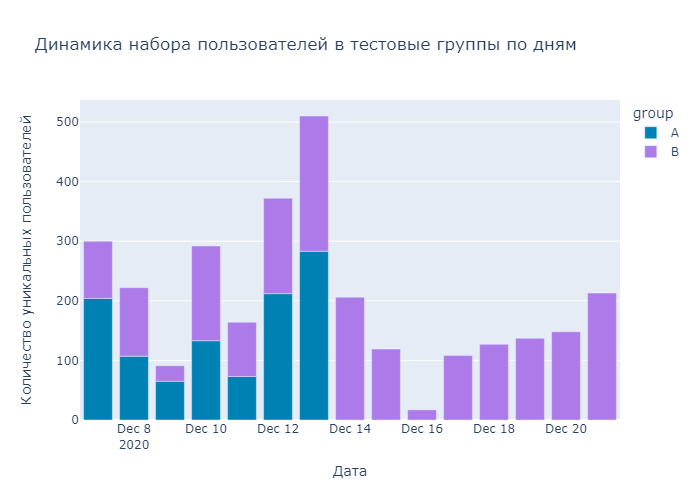

In [33]:
fig = px.bar(test_2, x='first_date', y='users_count', color='group', 
             title='Динамика набора пользователей в тестовые группы по дням', 
             color_discrete_sequence=['#0081B4', '#AD7BE9'])
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество уникальных пользователей')

fig.show("png")

In [34]:
test_2['users_count'].sum()

3026

***Как видно из графика после 14 декабря набор происходит только в группу B. Таких пользователей можно отфильтровать.***

### Распределение событий на одного пользователя в выборках

In [35]:
#количество событий по пользователями и событиям  
users_events = (recom_users_ab.groupby(['user_id', 'event_name'], as_index=False)['region'].count()
                              .rename(columns={'region':'events_count'})
                              .merge(recom_users_ab[['user_id', 'group']], on='user_id')
                              .drop_duplicates())

#количество событий по группам 
users_events_group = (users_events.groupby(['group', 'event_name'], as_index=False)['events_count'].agg('sum'))
users_events_group['event_by_user'] = 0

#количество оставшихся в тесте пользователей в группах А и В
users_A = recom_users_ab.query('group == "A"')['user_id'].nunique()
users_B = recom_users_ab.query('group == "B"')['user_id'].nunique()

#количество событий на одного пользователя 
users_events_group.loc[users_events_group['group'] == 'A', 'event_by_user'] = (
    users_events_group['events_count'] / users_A)

users_events_group.loc[users_events_group['group'] == 'B', 'event_by_user'] = (
    users_events_group['events_count'] / users_B)

In [36]:
print("Пользователей из группы А:", users_A)
print("Пользователй из группы B:", users_B)

Пользователей из группы А: 2747
Пользователй из группы B: 928


***Разница по количеству пользователей, при оценки пользовательских событий, стала ещё более ощутимой. Группа А - 2747 человек, B - 928 человек.***

In [37]:
users_events_group

,group,event_name,events_count,event_by_user
0,A,login,5922,2.155806
1,A,product_cart,1778,0.647252
2,A,product_page,3782,1.376775
3,A,purchase,1811,0.659265
4,B,login,2060,2.219828
5,B,product_cart,567,0.610991
6,B,product_page,1122,1.209052
7,B,purchase,537,0.578664


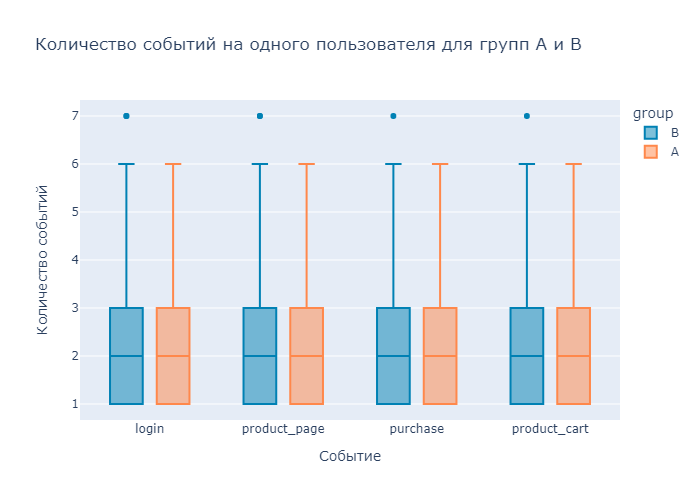

In [38]:
# отобразим это на графике
fig = px.box(users_events, x="event_name", y="events_count", color="group",
             title="Количество событий на одного пользователя для групп А и В", color_discrete_sequence=['#0081B4', '#FF884B'])

fig.update_xaxes(title_text='Событие')
fig.update_yaxes(title_text='Количество событий')

fig.show("png")

## <p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:
Из графика видно, что:
- Среднее количество событий login на одного клиента практически не различается между группами (A - 2.15, B - 2.21)
- По остальным событиям на одного пользователя группа А опережает группу В:
  - Просмотр страницы товара (А - 1.37, B - 1.2)
  - Добавление товара в корзину (А - 0.64, В - 0.61)
  - Покупка (А - 0.65, В - 0.57)

**Конверсия группы А выше, чем у группы В. Ожидаемый прирост в 10% не наблюдается.**
    
</div>

### Распределение событий и пользователей по дням

In [39]:
recom_users_ab.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,1
5,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,3


In [40]:
# преобразуем event_dt к datetime
recom_users_ab['event_dt'] = recom_users_ab['event_dt'].dt.date

events_by_date = (recom_users_ab.groupby(['event_dt', 'group'], as_index=False)['user_id'].count()
                                .rename(columns={'user_id':'events_count'}))
events_by_date.head()

,event_dt,group,events_count
0,2020-12-07,A,331
1,2020-12-07,B,378
2,2020-12-08,A,341
3,2020-12-08,B,252
4,2020-12-09,A,385


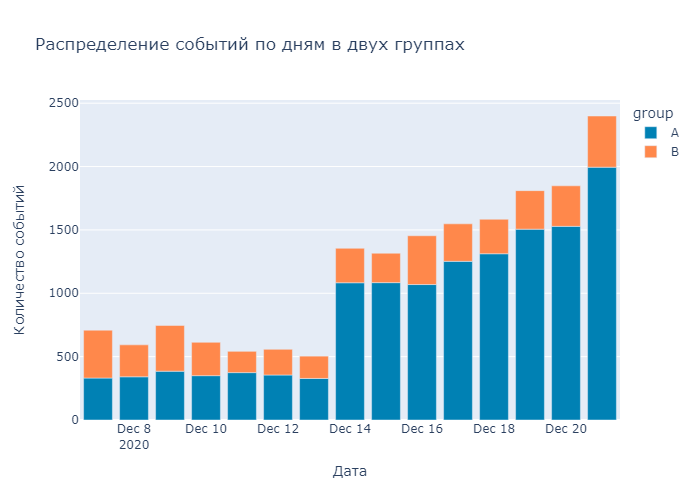

In [41]:
# отобразим на графике
fig = px.bar(events_by_date, x='event_dt', y='events_count', color='group', 
             title='Распределение событий по дням в двух группах', 
             color_discrete_sequence=['#0081B4', '#FF884B'])
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество событий')

fig.show("png")

##### <p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

- Пик событий приходится на 21 декабря (1995 в А и 404 событий в В)
- Только в первый день теста в группе В было больше событий, чем в группе А (378 против 331 события). В остальных днях группа А опережала группу В по количеству событий.
- С 14 декабря наблюдаем резкий рост количества событий для группы А.
    
</div>

In [42]:
#распределение количества активных пользователей по дням
users_by_date = (recom_users_ab.groupby(['event_dt', 'group'], as_index=False)['user_id'].nunique()
                .rename(columns={'user_id':'users_count'}))
users_by_date.head()

,event_dt,group,users_count
0,2020-12-07,A,154
1,2020-12-07,B,173
2,2020-12-08,A,160
3,2020-12-08,B,120
4,2020-12-09,A,178


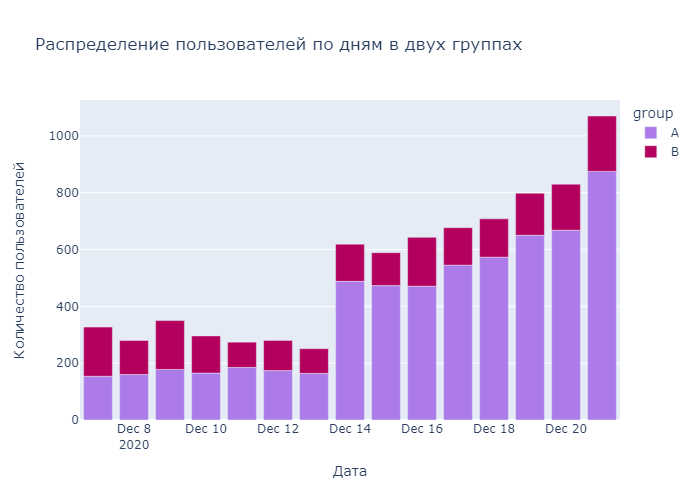

In [43]:
fig = px.bar(users_by_date, x='event_dt', y='users_count', color='group', 
             title='Распределение пользователей по дням в двух группах',
             color_discrete_sequence=['#AD7BE9', '#B3005E'])
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество пользователей')

fig.show("png")

<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

Картина аналогичная графику по событиям. Поэтому резкий рост количества событий с 14 декабря - это логичное явление, т.к. увеличилось кол-во пользователей. 
    
</div>

### Изменение конверсии в воронке на разных этапах

In [44]:
# определяем переменные для создания воронки
funnel_A = recom_users_ab[recom_users_ab['group']=="A"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_A.columns = ['event_count','user_count']
funnel_A = funnel_A.sort_values(by = 'event_count', ascending = False).reset_index().reindex([0,1,3,2])

funnel_B = recom_users_ab[recom_users_ab['group']=="B"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_B.columns = ['event_count','user_count']
funnel_B = funnel_B.sort_values(by = 'event_count', ascending = False).reset_index()

In [45]:
funnel_B

,event_name,event_count,user_count
0,login,2060,927
1,product_page,1122,523
2,product_cart,567,255
3,purchase,537,256


In [46]:
funnel_A

,event_name,event_count,user_count
0,login,5922,2747
1,product_page,3782,1780
3,product_cart,1778,824
2,purchase,1811,872


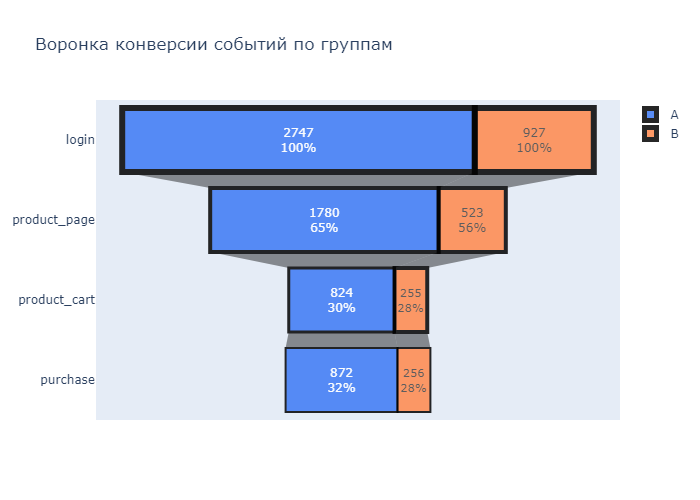

In [47]:
# строим воронку конверсии событий по группам

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_A['event_name'],
    x = funnel_A['user_count'],
    opacity = 0.85, marker = {"color": ["#3C79F5", "#3C79F5", "#3C79F5", "#3C79F5"],
    "line": {"width": [6, 4, 3, 2, 1], "color": ["black", "black", "black", "black"]}},
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_B['event_name'],
    x = funnel_B['user_count'],
    opacity = 0.85, marker = {"color": ["#FF884B", "#FF884B", "#FF884B", "#FF884B"],
    "line": {"width": [6, 4, 4, 2, 1], "color": ["black", "black", "black", "black"]}},
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text = 'Воронка конверсии событий по группам')
fig.show("png")

## <p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

До покупки доходят 30% пользователей группы А и 28% пользователей группы В.
Меньше всего разница в конверсии между product_cart и purchase - добавлением товара в корзине и его покупкой (разница в 2% у группы А и у группы В нет разницы)
Больше всего падает коверсия между login и product_page уровнями - логином и просмотром страницы товара (-35% у группы А и -46% у группы В)
    
</div>

## A/B - тестирование

### Изменение метрик за 14 дней с момента регистрации пользователя

In [48]:
# еще раз преобразуем event_dt к datetime. т.к. тип снова поменялся на object
recom_users_ab['event_dt'] = pd.to_datetime(recom_users_ab['event_dt'])

In [49]:
recom_users_ab.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN,0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN,0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN,0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN,1
5,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN,3


In [50]:
#создаем табличку по столбцам 'lifetime', 'group', 'event_name' и с кол-вом событий
conversion = (recom_users_ab.groupby(['lifetime', 'group', 'event_name'], as_index=False)['user_id'].count()
                  .rename(columns={'user_id':'events_count'}))
conversion.head()

,lifetime,group,event_name,events_count
0,0,A,login,2738
1,0,A,product_cart,823
2,0,A,product_page,1777
3,0,A,purchase,869
4,0,B,login,911


In [51]:
# создаем датафрейм с событиями product_page
product_pages = conversion.query('event_name == "product_page"')
# добавляем расчёт cumsum от количества событий
product_pages['events_cumsum'] = product_pages.groupby('group')['events_count'].cumsum()

# расчёт роста количества событий типа product_page для двух групп за 14 дней лайфтайма
a_product_pages = round((product_pages.iloc[-2]['events_cumsum'] - product_pages.iloc[0]['events_cumsum']) 
                        / product_pages.iloc[0]['events_cumsum'], 3) 
b_product_pages = round((product_pages.iloc[-1]['events_cumsum'] - product_pages.iloc[1]['events_cumsum']) 
                        / product_pages.iloc[1]['events_cumsum'], 3) 

In [52]:
# аналогичные действия для события product_cart

product_carts = conversion.query('event_name == "product_cart"')
product_carts['events_cumsum'] = product_carts.groupby('group')['events_count'].cumsum()

#расчёт роста количества событий типа product_cart для двух групп за 14 дней лайфтайма
a_product_carts = round((product_carts.iloc[-2]['events_cumsum'] - product_carts.iloc[0]['events_cumsum']) 
                        / product_carts.iloc[0]['events_cumsum'], 3) 
b_product_carts = round((product_carts.iloc[-1]['events_cumsum'] - product_carts.iloc[1]['events_cumsum']) 
                        / product_carts.iloc[1]['events_cumsum'], 3)

In [53]:
# аналогичные действия для события purchases

#датафрейм только с событиями типа purchases
purchases = conversion.query('event_name == "purchase"')
purchases['events_cumsum'] = purchases.groupby('group')['events_count'].cumsum()

#расчёт роста количества событий типа purchases для двух групп за 14 дней лайфтайма
a_purchases = round((purchases.iloc[-2]['events_cumsum'] - purchases.iloc[0]['events_cumsum']) 
                     / purchases.iloc[0]['events_cumsum'], 3) 
b_purchases = round((purchases.iloc[-1]['events_cumsum'] - purchases.iloc[1]['events_cumsum']) 
                    / purchases.iloc[1]['events_cumsum'], 3)

In [54]:
# выводим получившиеся рез-ты

print("Группа А - просмотр страницы товара:", a_product_pages)
print("Группа B - просмотр страницы товара:", b_product_pages, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа A - добавление товара в корзину:", a_product_carts)
print("Группа B - добавление товара в корзину:", b_product_carts, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа А - покупки:", a_purchases)
print("Группа B - покупки:", b_purchases)

Группа А - просмотр страницы товара: 1.128
Группа B - просмотр страницы товара: 1.2

---------------------------------------------------------------------------------------------------------
Группа A - добавление товара в корзину: 1.16
Группа B - добавление товара в корзину: 1.268

---------------------------------------------------------------------------------------------------------
Группа А - покупки: 1.084
Группа B - покупки: 1.123


<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

За 2 недели лайфтайма пользователя группа А опережает группу В.

Просмотр страницы товара, рост за 2 недели с момента регистрации пользователя:
- Группа А - рост на 12,8%
- Группа B - рост на 20%

Добавление товара в корзину, рост за 2 недели с момента регистрации пользователя:
- Группа А - рост на 16%
- Группа B - рост на 26,8%

Покупка товара, рост за 2 недели с момента регистрации пользователя:
- Группа А - рост на 8,4 %
- Группа B - рост на 12,3%
    
</div>

## Проверка статистической разницы долей z-критерием

*Проведем сравнение пропорций для основных метрик - product_page, product_cart и purchase с помощью z-критерия.*

***Нулевая гипотеза:*** Доли значений метрик в группах равны

***Альтернативная гипотеза:*** Доли значений метрик в группах не равны

***Критический уровень значимости (альфа):*** Будем рассчитывать с помощью ***поправки Бонферрони***, так как мы будем проводить множественные тесты на одинаковом наборе данных (без сбора новых наблюдений). Выберем альфа ***равное 0.05***, а с ***поправкой альфа будет равна 0.05 / 3 = 0.016***

Т.к. количество пользователей в группах отличается, то будем проверять z-критерием количество событий на одного пользователя, чтобы компенсировать разницу по количеству пользователей в группах.

In [55]:
#таблица по lifetime, group, + количество событий
users_count = (recom_users_ab.groupby(['lifetime','group'], as_index=False)['user_id'].nunique()
               .rename(columns={'user_id':'users_count'}))

#события типа product_page
product_pages = product_pages.merge(users_count, on=['lifetime', 'group'])
product_pages['event_by_user'] = product_pages['events_count'] / product_pages['users_count']

#события типа product_cart
product_carts = product_carts.merge(users_count, on=['lifetime', 'group'])
product_carts['event_by_user'] = product_carts['events_count'] / product_carts['users_count']

#события типа purchase
purchases = purchases.merge(users_count, on=['lifetime', 'group'])
purchases['event_by_user'] = purchases['events_count'] / purchases['users_count']

In [56]:
# смотрим на средние значения ключевых метрик
print('Тип события product_pages')
display(product_pages.groupby('group')['event_by_user'].mean())
print('Тип события product_carts')
display(product_carts.groupby('group')['event_by_user'].mean())
print('Тип события purchases')
display(purchases.groupby('group')['event_by_user'].mean())

Тип события product_pages


group
A    0.632933
B    0.538362
Name: event_by_user, dtype: float64

Тип события product_carts


group
A    0.274869
B    0.291066
Name: event_by_user, dtype: float64

Тип события purchases


group
A    0.272584
B    0.263668
Name: event_by_user, dtype: float64

***Можно заметить, что наибольшее отличие в количестве событий на пользователя для метрики product_pages, для остальных метрик разницы в значениях почти нет.***

In [57]:
# функция для расчета z-test
def func_z_test(event):
    z_test = ztest(event.query('group == "A"')['event_by_user'], 
                   event.query('group == "B"')['event_by_user'], value=0)[1]
    print("p-value:", z_test)

In [58]:
func_z_test(product_pages)

p-value: 0.00044194877853921796


In [59]:
func_z_test(product_carts)

p-value: 0.45802870383641603


In [60]:
func_z_test(purchases)

p-value: 0.7305785686680758


<p></p>
<div style="border:solid black 4px; padding: 10px">

***Вывод***:

**Только по метрике - product_pages p-value оказался меньше, чем альфа. Для долей этой метрики есть значимая разница**. Для двух других метрик p-value меньше альфы; **между долями нет значимой разницы.**
    
</div>

## Общий вывод:

1. Первое, на что стоит обратить внимание - это то, что количество пользователей в группах А и В было разным. 
   - В группе А присутствует 3824 человека
   - В группе В - 2877 человек 
Всего 6701 человек, группы делятся не равномерно - 57% (А) и 43% (В). На этапе анализа событий ситуация стала ещё хуже - в группе А 2747 человек (75%), в группе В 928 человек (25%). Данное обстоятельство уже значительно будет сказываться на тесте. Можно констатировать, что проведение теста по таким данным не является корректным. Однако, можно посмотреть результаты этого теста.

2. Среднее количество событий login на одного клиента практически не различается между группами (A - 2.15, B - 2.21). По остальным событиям на одного пользователя группа А опережает группу В:
   - Просмотр страницы товара (А - 1.37, B - 1.2)
   - Добавление товара в корзину (А - 0.64, В - 0.61)
   - Покупка (А - 0.65, В - 0.57)

3. Пик событий приходится на 21 декабря (1995 в А и 404 событий в В). Только в первый день теста в группе В было больше событий, чем в группе А (378 против 331 события). В остальных днях группа А опережала группу В по количеству событий. С 14 декабря наблюдаем резкий рост количества событий для группы А.

4. До покупки доходят 30% пользователей группы А и 28% пользователей группы В. Меньше всего разница в конверсии между product_cart и purchase - добавлением товара в корзине и его покупкой (разница в 2% у группы А и у группы В нет разницы). Больше всего падает коверсия между login и product_page уровнями - логином и просмотром страницы товара (-35% у группы А и -46% у группы В)

5. Смотря на изменение ключевых метрик за 14 дней с момента регистрации пользователя можно утверждать, что за 2 недели лайфтайма пользователя группа А опережает группу В по росту всех основных метрик, хотя в некоторых случаях разница и не столь велика.

6. Проверка гипотез о равенстве долей для основных метрик показала, что только по одному типу события - product_pages p-value оказался меньше, чем критический уровень значимости (альфа). Для долей этого события есть значимая разница. Для двух других метрик p-value меньше альфы, то есть между долями нет значимой разницы.

Проведя тест получили, что группа А является лучшей из двух групп по показателям основных метрик. Однако, ***сам тест не является полностью корректным, поэтому не стоит полагаться на его результаты.***